# 0.0 Imports

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics.pairwise import cosine_similarity

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def print_neighbors(suggestions, books_pivot):
    for i in range(len(suggestions)):
        for neighbor_index in suggestions[i]:
            neighbor_id = books_pivot.index[neighbor_index]
            if neighbor_id != 'The Da Vinci Code':
                print(neighbor_id)

def recommend(book_name):
    # index fetch
    index = np.where(books_pivot.index == book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])), key=lambda x: x[1], reverse=True)[1:5]

    recommended_books = []
    for i in similar_items:
        recommended_books.append(books_pivot.index[i[0]])

    return recommended_books

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
# Loading dataset
df_users = pd.read_csv('../data/Users.csv', low_memory=False)
df_ratings = pd.read_csv('../data/Ratings.csv', low_memory=False)
df_books = pd.read_csv('../data/Books.csv', low_memory=False)

In [5]:
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


## 0.3 Removing useless columns 

In [8]:
# Drop
df_books = df_books.drop( columns=['Image-URL-M', 'Image-URL-S', 'Year-Of-Publication', 'Publisher', 'Book-Author'], axis=1 )

# 1.0 Data Description

## 1.1 Rename columns

In [9]:
# Changing columns names
df_ratings = df_ratings.rename(columns={'User-ID': 'user_id', 'ISBN': 'isbn', 'Book-Rating': 'book_rating'})

df_books = df_books.rename(columns={'ISBN': 'isbn', 'Book-Title': 'book_title', 'Image-URL-L': 'image_url_l'})

## 1.2 Data dimensions

In [10]:
print("Número de linhas do dataset com ratings: {}".format(df_ratings.shape[0]))
print("Número de colunas do dataset com ratings: {}".format(df_ratings.shape[1]))

Número de linhas do dataset com ratings: 1149780
Número de colunas do dataset com ratings: 3


In [11]:
print("Número de linhas do dataset sobre livros: {}".format(df_books.shape[0]))
print("Número de colunas do dataset sobre livros: {}".format(df_books.shape[1]))

Número de linhas do dataset sobre livros: 271360
Número de colunas do dataset sobre livros: 3


## 1.3 Data Types

In [12]:
df_ratings.dtypes

user_id         int64
isbn           object
book_rating     int64
dtype: object

In [13]:
df_books.dtypes

isbn           object
book_title     object
image_url_l    object
dtype: object

## 1.4 Check NA

In [14]:
df_ratings.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

In [15]:
df_books.isna().sum()

isbn           0
book_title     0
image_url_l    3
dtype: int64

## 1.5 Fill NA

In [20]:
# Dropando valores NA na coluna 'image_url_l'
df_books = df_books.dropna(subset='image_url_l')

## 1.6 Descriptive Statistical

In [21]:
df_ratings.describe().round(1)

,user_id,book_rating
count,1149780.0,1149780.0
mean,140386.4,2.9
std,80562.3,3.9
min,2.0,0.0
25%,70345.0,0.0
50%,141010.0,0.0
75%,211028.0,7.0
max,278854.0,10.0


## 1.6 Merging datasets

In [22]:
# Merging - Inner Join
df1 = pd.merge(df_ratings, df_books, on='isbn')

### 1.6.1 Checking new dataset

In [23]:
df1.head()

,user_id,isbn,book_rating,book_title,image_url_l
0,276725,034545104X,0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...


In [24]:
df1.isna().sum()

user_id        0
isbn           0
book_rating    0
book_title     0
image_url_l    0
dtype: int64

In [25]:
print("Número de linhas do novo dataset: {}".format(df1.shape[0]))
print("Número de colunas do novo dataset: {}".format(df1.shape[1]))

Número de linhas do novo dataset: 1031132
Número de colunas do novo dataset: 5


## 1.7 Most Popular Books

In [26]:
popular_books = pd.DataFrame(df1.groupby('book_title')['book_rating'].count())

most_popular = popular_books.sort_values('book_rating', ascending=False)

top_10 = most_popular.head(10).reset_index()
top_10

,book_title,book_rating
0,Wild Animus,2502
1,The Lovely Bones: A Novel,1295
2,The Da Vinci Code,898
3,A Painted House,838
4,The Nanny Diaries: A Novel,828
5,Bridget Jones's Diary,815
6,The Secret Life of Bees,774
7,Divine Secrets of the Ya-Ya Sisterhood: A Novel,740
8,The Red Tent (Bestselling Backlist),723
9,Angels &amp; Demons,670


### 1.7.1 Graph Visualization

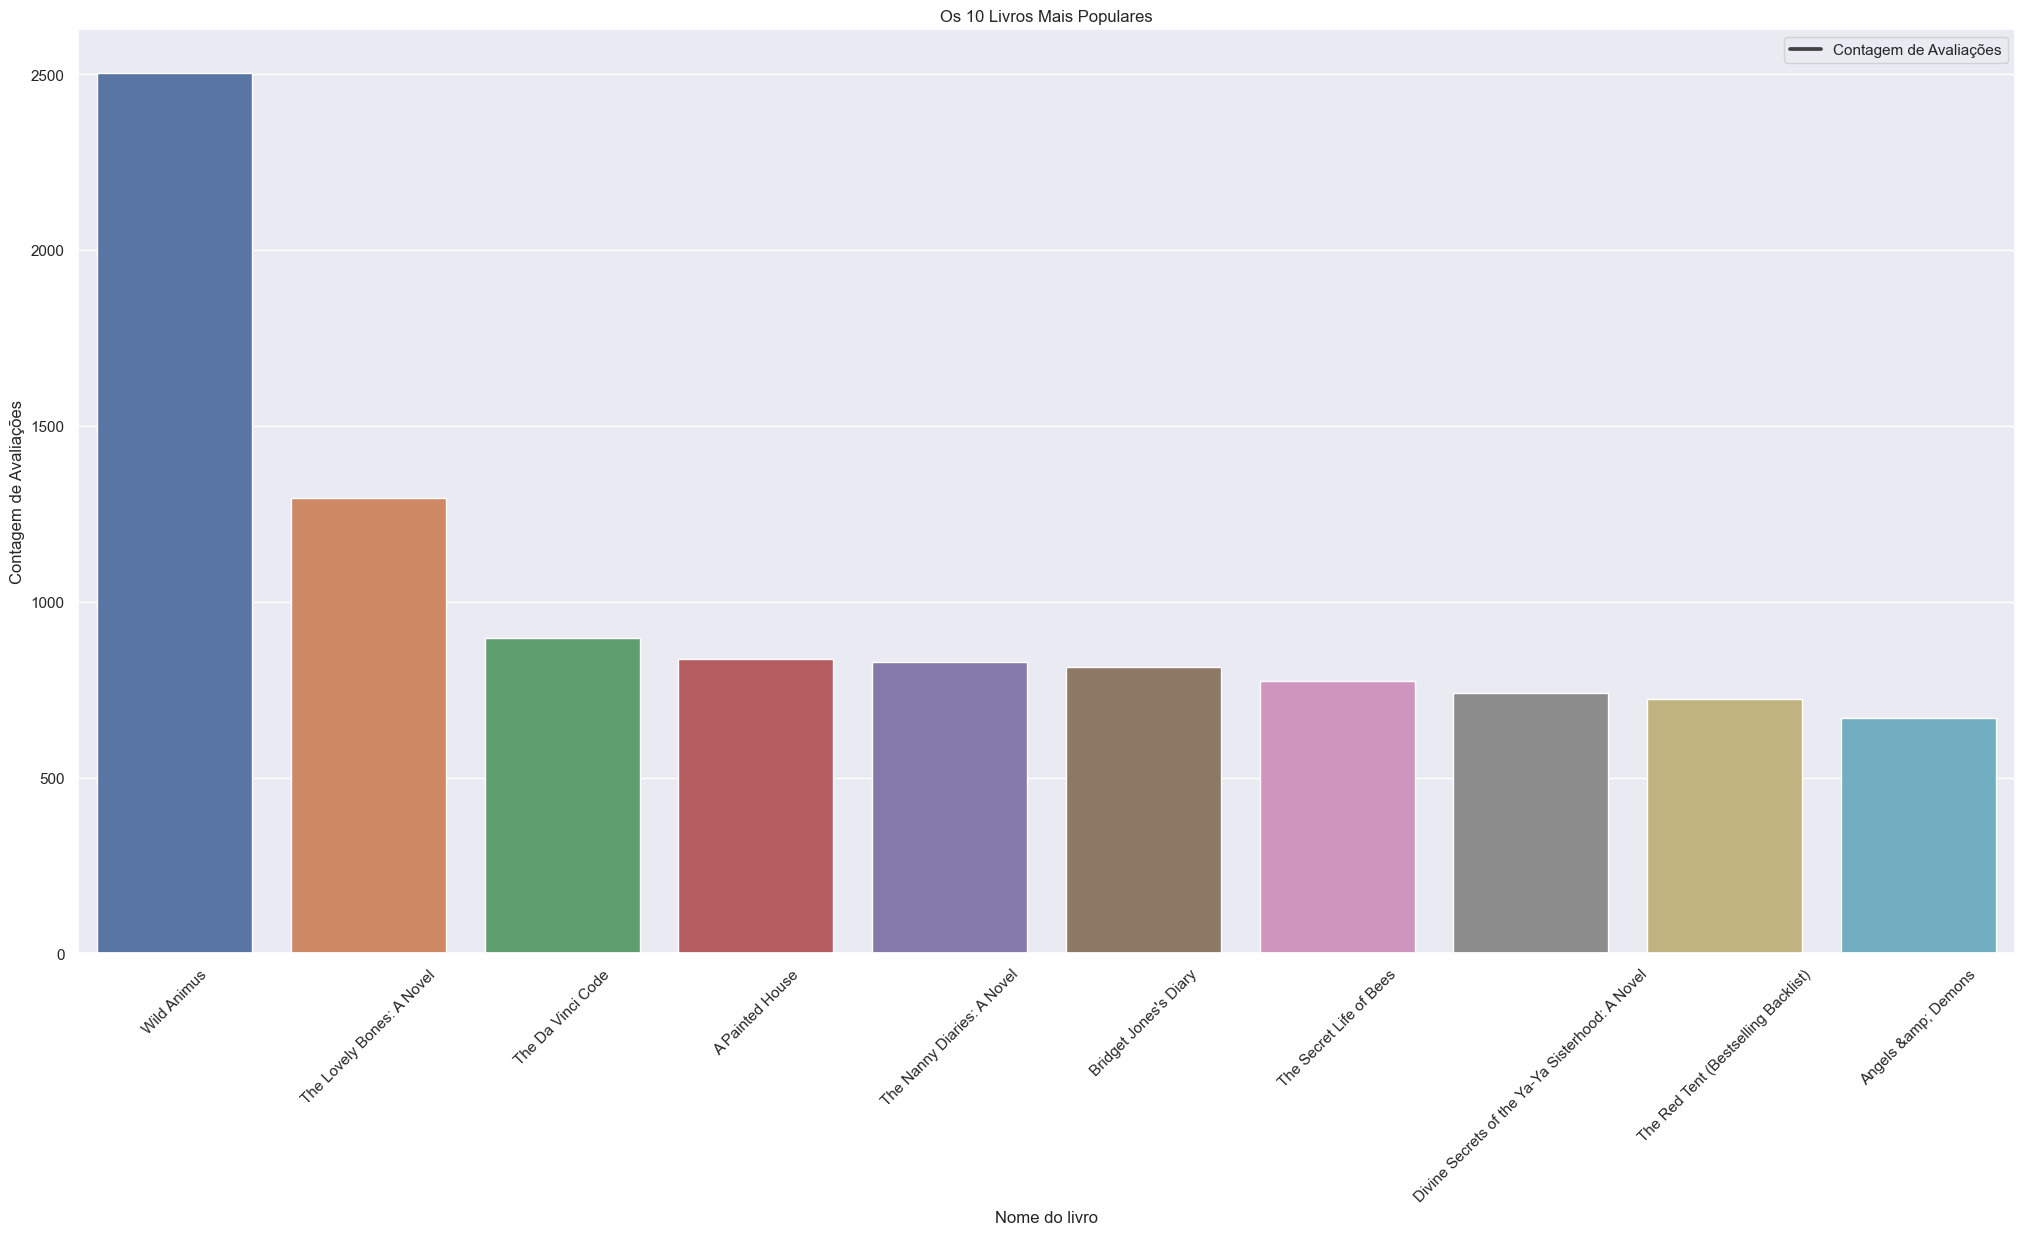

In [27]:
# Gráfico de barras com Seaborn
sns.barplot(x='book_title', y='book_rating', data=top_10)

# Adicione legendas
plt.xlabel('Nome do livro')
plt.ylabel('Contagem de Avaliações')
plt.title('Os 10 Livros Mais Populares')

# Exiba o gráfico
plt.xticks(rotation=45)

# Defina as legendas
legend_labels = ['Contagem de Avaliações']

# Adicione as legendas ao gráfico
plt.legend(legend_labels)

# Mostrar o gráfico
plt.show()

# 2.0 Counting Values

In [28]:
# Calcular a contagem de avaliações por 'user_id'
df_counts = df1['user_id'].value_counts().reset_index()

# Renomear as colunas
df_counts.columns = ['user_id', 'counts']

# Exibir o DataFrame
df_counts.head(10)

,user_id,counts
0,11676,11144
1,198711,6456
2,153662,5814
3,98391,5779
4,35859,5646
5,212898,4289
6,278418,3996
7,76352,3329
8,110973,2971
9,235105,2943


In [29]:
difference = df_counts['counts'].max() - df_counts['counts'].min()
difference

11143

## 2.1 Merging and Filtering

In [30]:
# Merging - Inner Join
df2 = pd.merge(df1, df_counts, on='user_id')

# Filtering 
df2_filtered = df2[df2['counts'] > 999]

# Visualization
df2_filtered.head()

,user_id,isbn,book_rating,book_title,image_url_l,counts
654,23768,034545104X,0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...,1690
655,23768,0446520802,6,The Notebook,http://images.amazon.com/images/P/0446520802.0...,1690
656,23768,038550120X,0,A Painted House,http://images.amazon.com/images/P/038550120X.0...,1690
657,23768,0425115801,0,Lightning,http://images.amazon.com/images/P/0425115801.0...,1690
658,23768,055356451X,0,Night Sins,http://images.amazon.com/images/P/055356451X.0...,1690


In [31]:
df2_filtered.shape

(199006, 6)

## 2.2 Checking NA

In [32]:
df2_filtered.isna().sum()

user_id        0
isbn           0
book_rating    0
book_title     0
image_url_l    0
counts         0
dtype: int64

## 2.3 Drop Duplicates

In [33]:
df2_filtered = df2_filtered.copy()

df2_filtered.drop_duplicates(['user_id','book_title'], inplace = True)

## 2.4 Pivot

In [34]:
books_pivot = df2_filtered.pivot_table(columns = 'user_id', index = 'book_title', values = 'book_rating')

# Avaliar o arquivo transformado para PIVOT 
books_pivot.head(10)

user_id,11601,11676,12538,16634,16795,23768,23902,26544,31315,31556,35050,35857,35859,36606,36836,40943,43246,51883,52584,52614,55492,56399,56447,56959,60244,69697,73394,76352,76499,78783,87141,87555,88733,93047,95359,98391,98741,102967,107784,110973,114414,115120,123981,127233,127429,129358,130474,135149,142524,147847,148744,153662,156150,158295,162639,166123,166596,167800,171118,172030,172742,174304,175003,177458,182085,184299,185233,189334,189835,190925,196077,198711,200674,204864,212898,213350,225087,225810,226545,227447,228998,230522,231210,232131,234623,234828,235105,236283,238120,238781,242824,245827,245963,246655,248718,251613,254465,257204,265115,266226,269566,271284,274061,274308,275970,278418
book_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Always Have Popsicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apple Magic (The Collector's series),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beyond IBM: Leadership Marketing and Finance for the 1990s,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dark Justice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Deceived,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## 2.5 Fill NA

In [35]:
# Os valores que são nulos iremos preencher com ZERO
books_pivot.fillna(0, inplace = True)
books_pivot.head()

user_id,11601,11676,12538,16634,16795,23768,23902,26544,31315,31556,35050,35857,35859,36606,36836,40943,43246,51883,52584,52614,55492,56399,56447,56959,60244,69697,73394,76352,76499,78783,87141,87555,88733,93047,95359,98391,98741,102967,107784,110973,114414,115120,123981,127233,127429,129358,130474,135149,142524,147847,148744,153662,156150,158295,162639,166123,166596,167800,171118,172030,172742,174304,175003,177458,182085,184299,185233,189334,189835,190925,196077,198711,200674,204864,212898,213350,225087,225810,226545,227447,228998,230522,231210,232131,234623,234828,235105,236283,238120,238781,242824,245827,245963,246655,248718,251613,254465,257204,265115,266226,269566,271284,274061,274308,275970,278418
book_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Always Have Popsicles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Apple Magic (The Collector's series),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Beyond IBM: Leadership Marketing and Finance for the 1990s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dark Justice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.6 Sparse Matrix

In [36]:
books_sparse = csr_matrix(books_pivot)

## 2.7 Training NearestNeighbors model

In [37]:
# Criando e treinando o modelo preditivo para encontrar os vizinhos mais próximos
modelo = NearestNeighbors(algorithm = 'brute')
modelo.fit(books_sparse)

NearestNeighbors(algorithm='brute')

## 2.8 Testing

## 2.8.1 Book: The Da Vinci Code

In [38]:
distances, suggestions = modelo.kneighbors(books_pivot.filter(items=['The Da Vinci Code'], axis=0).values.reshape(1, -1))

# Supondo que você já tenha definido 'suggestions' e 'books_pivot'
print_neighbors(suggestions, books_pivot)

Back When We Were Grownups: A Novel
My Sister's Keeper : A Novel (Picoult, Jodi)
Indigo Dying
The Jester


### 2.8.2 Book: Dark Justice

In [39]:
distances, suggestions = modelo.kneighbors(books_pivot.filter(items=['Dark Justice'], axis=0).values.reshape(1, -1))

# Supondo que você já tenha definido 'suggestions' e 'books_pivot'
print_neighbors(suggestions, books_pivot)

 Apple Magic (The Collector's series)
 Always Have Popsicles
 A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)
 Deceived
 Beyond IBM: Leadership Marketing and Finance for the 1990s


## 2.9 Testing with cosine similarity

In [40]:
similarity_scores = cosine_similarity(books_sparse)

### 2.9.1 Book: The Da Vinci Code

In [41]:
recommend('The Da Vinci Code')

['Back When We Were Grownups: A Novel',
 'Out of Sight',
 'Indigo Dying',
 'The Jester']

### 2.9.2 Book: Dark Justice

In [42]:
recommend('Dark Justice')

[' Always Have Popsicles',
 " Apple Magic (The Collector's series)",
 ' Beyond IBM: Leadership Marketing and Finance for the 1990s',
 ' Dark Justice']

# 3.0 Deploy to production

In [81]:
# Lista vazia para armazenar as imagens
imagens = []

fig_style = 'style="display:inline-block; text-align:center; margin:5px;"'

livro_inicial = 'The Da Vinci Code'

# Obtenha as recomendações usando similaridade de cosseno
suggestions = recommend(livro_inicial)

print("Se você leu '{}', as sugestões são:\n".format(livro_inicial))

# Loop para iterar sobre as recomendações
for i, suggestion in enumerate(suggestions):
    titulo, url_capa = df2_filtered.loc[df2_filtered['book_title'] == suggestion, ['book_title', 'image_url_l']].values[0]

    imagem_html = f'<figure {fig_style}><img src="{url_capa}" width="100" height="200"><figcaption>{suggestion}</figcaption></figure>'
    
    imagens.append(imagem_html)

    print(f'Sugestão {i + 1}: {suggestion}')

# Exibindo as imagens dentro de uma div com estilo flex
display(HTML('<div style="display: flex; flex-wrap: wrap;">' + ''.join(imagens) + '</div>'))

Se você leu 'The Da Vinci Code', as sugestões são:

Sugestão 1: Back When We Were Grownups: A Novel
Sugestão 2: Out of Sight
Sugestão 3: Indigo Dying
Sugestão 4: The Jester
